In [21]:
from BoomboxProcessor import BoomboxProcessor
import numpy as np

In [22]:
# load the data
data_folder = "/home/shrey/Documents/eecs448-boombox/data/gtzan/"
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

boombox = BoomboxProcessor(verbose=True)
boombox.load_trajectories(data_folder, genres, "trajs.pkl")

Loaded 100 trajectories from blues
Loaded 100 trajectories from classical
Loaded 100 trajectories from country
Loaded 100 trajectories from disco
Loaded 100 trajectories from hiphop
Loaded 99 trajectories from jazz
Loaded 100 trajectories from metal
Loaded 100 trajectories from pop
Loaded 100 trajectories from reggae
Loaded 100 trajectories from rock


In [23]:
boombox.encode_trajectories_pca()

100%|██████████| 100/100 [00:01<00:00, 54.61it/s]


In [24]:
boombox.split_encoded_trajectories(7)

In [25]:
trajs, labels = boombox.get_all_songlet_trajectories()

In [26]:
np.all(np.sum(np.abs(trajs.reshape(-1, 768))**2, axis=1)**(1./2) - 1 < 1e-5)

True

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trajs, labels, test_size=0.2, random_state=42)


In [65]:
from torch.utils.data import Dataset, DataLoader

class TrajectoryDataset(Dataset):
    def __init__(self, trajs, labels, S):
        super(Dataset, self).__init__()
        self.trajs = trajs
        self.labels = labels
        self.S = S
    
    def __len__(self):
        return self.trajs.shape[0]

    def __getitem__(self, idx):
        return self.trajs[idx:idx+1], self.labels[idx]
dataset = TrajectoryDataset(X_train, y_train, boombox.num_songlets)

In [66]:
import torch

def train_epoch(model, device, dataloader, loss_fxn, optimizer):
    model.train()

    train_loss, train_correct = 0.0, 0

    for X, y in dataloader:
        X, y = X.float().to(device), y.long().to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fxn(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)
        _, preds = torch.max(output, 1)
        train_correct += torch.sum(preds == y).item()
    
    return train_loss, train_correct

def valid_epoch(model, device, dataloader, loss_fxn):
    val_loss, val_correct = 0.0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.float().to(device), y.long().to(device)
            output = model(X)
            loss = loss_fxn(output, y)
            val_loss += loss.item() * X.size(0)
            _, preds = torch.max(output, 1)
            val_correct += torch.sum(preds == y).item()
    
    return val_loss, val_correct

In [142]:
import torch.nn as nn

class GenreClassifier2D(nn.Module):
    def __init__(self):
        super(GenreClassifier2D, self).__init__()
        self.conv_group = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(1,3), stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(1,3), stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1,3), stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self.flatten = nn.Flatten()
        self.droput = nn.Dropout(p=0.4)

        self.fc_group = nn.Sequential(
            nn.Linear(3072, 512),
            # nn.BatchNorm1d(512),
            nn.ReLU(),
            # nn.Dropout(p=0.3),
            nn.Linear(512, 10),
            # nn.BatchNorm1d(128),
            # nn.ReLU(),
            # nn.Dropout(p=0.3),
            # nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_group(x)
        x = self.flatten(x)
        x = self.droput(x)
        x = self.fc_group(x)

        return x

In [143]:
trajs.shape

(999, 7, 768)

In [149]:
# define constants
BATCH_SIZE = 32
EPOCHS = 200
LR = 0.01
WEIGHT_DECAY = 1e-4
S = 7
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# test model on a single datapoint
model = GenreClassifier2D()

model.to(device)
X = torch.randn(1, S, 768).to(device)
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
print(model(X).shape)

torch.Size([1, 10])


In [153]:
from sklearn.model_selection import KFold

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [154]:
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm

log_epochs = 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
train_loss_list = dict()
test_loss_list = dict()
train_acc_list = dict()
test_acc_list = dict()
iters = dict()


for i, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print("Training fold {}...".format(i+1))
    train_loss_list[i] = []
    test_loss_list[i] = []
    train_acc_list[i] = []
    test_acc_list[i] = []
    iters[i] = []

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

    model = GenreClassifier2D().to(device)
    loss_fxn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    recent_val_acc = 0

    # print(f"Fold {i+1}/{n_splits} training with {len(train_loader.sampler)} training samples and {len(val_loader.sampler)} validation samples...")
    
    for epoch in (pbar := tqdm(range(EPOCHS))):
        train_loss, train_correct = train_epoch(model, device, train_loader, loss_fxn, optimizer)

        if epoch % log_epochs == 0:
            val_loss, val_correct = valid_epoch(model, device, val_loader, loss_fxn)

            train_loss_list[i].append(train_loss/len(train_loader.sampler))
            test_loss_list[i].append(val_loss/len(val_loader.sampler))
            train_acc_list[i].append(train_correct/len(train_loader.sampler))
            test_acc_list[i].append(val_correct/len(val_loader.sampler))
            iters[i].append(epoch)

        if epoch % log_epochs == 0:
            # print("Epoch: {}, Train Loss: {}, Train Acc: {}, Val Loss: {}, Val Acc: {}".format(epoch, train_loss/len(train_loader.sampler), train_correct/len(train_loader.sampler), val_loss/len(val_loader.sampler), val_correct/len(val_loader.sampler)))
            # pbar.set_description(f"Fold {i+1}/{n_splits} Epoch {epoch+1}/{EPOCHS}\t Train Acc: {train_correct/len(train_loader.sampler):.4f}\t Val Acc: {val_correct/len(val_loader.sampler):.4f}")
            pbar.set_description(f"Fold {i+1}/{n_splits} Epoch {epoch+1}/{EPOCHS}\t Train Acc: {train_correct/len(train_loader.sampler):.4f}\t Val Acc: {val_correct/len(val_loader.sampler):.4f}")

Using device: cuda:0
Training fold 1...


Fold 1/10 Epoch 193/200	 Train Acc: 0.5665	 Val Acc: 0.4938: 100%|██████████| 200/200 [00:19<00:00, 10.43it/s]


Training fold 2...


Fold 2/10 Epoch 193/200	 Train Acc: 0.4632	 Val Acc: 0.4750: 100%|██████████| 200/200 [00:18<00:00, 10.57it/s]


Training fold 3...


Fold 3/10 Epoch 193/200	 Train Acc: 0.6401	 Val Acc: 0.5625: 100%|██████████| 200/200 [00:18<00:00, 10.63it/s]


Training fold 4...


Fold 4/10 Epoch 193/200	 Train Acc: 0.5759	 Val Acc: 0.5813: 100%|██████████| 200/200 [00:18<00:00, 10.56it/s]


Training fold 5...


Fold 5/10 Epoch 193/200	 Train Acc: 0.8141	 Val Acc: 0.5849: 100%|██████████| 200/200 [00:19<00:00, 10.46it/s]


KeyError: 5

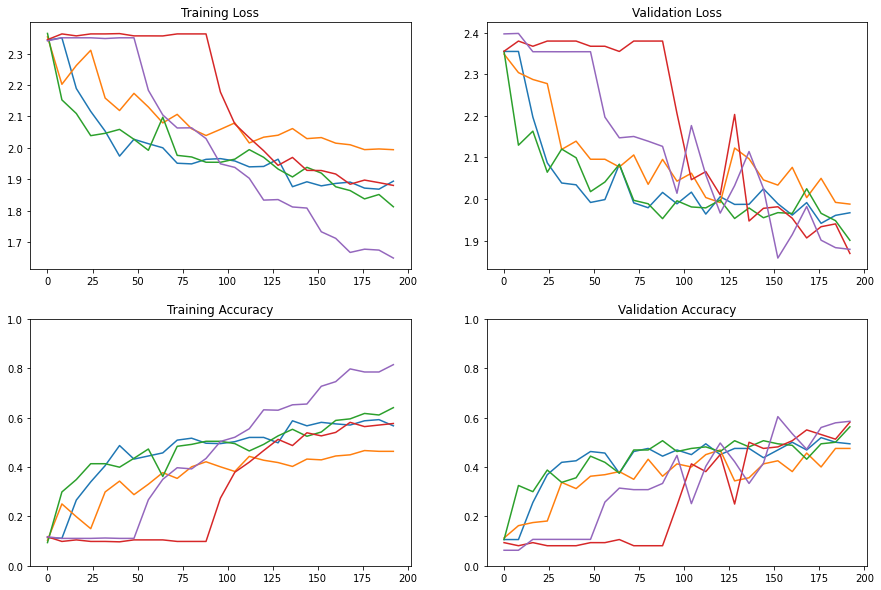

In [155]:
import matplotlib.pyplot as plt

# save graphs
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].set_title("Training Loss")
ax[0, 1].set_title("Validation Loss")
ax[1, 0].set_title("Training Accuracy")
ax[1, 1].set_title("Validation Accuracy")

ax[1, 0].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)
                
for i in range(n_splits):
    ax[0, 0].plot(iters[i], train_loss_list[i], label="Fold {}".format(i+1))
    ax[0, 1].plot(iters[i], test_loss_list[i], label="Fold {}".format(i+1))
    ax[1, 0].plot(iters[i], train_acc_list[i], label="Fold {}".format(i+1))
    ax[1, 1].plot(iters[i], test_acc_list[i], label="Fold {}".format(i+1))

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()